In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Catfish Sales Data

In [72]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output dataframe.csv

'gdown' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [3]:
df = pd.read_csv('dataframe.csv', parse_dates=['Date'], index_col='Date')
#df = pd.read_csv('dataframe.csv')
#df['Date'] = pd.to_datetime(df['Date'])
#df.set_index('Date', inplace=True)
#df = df.sort_values(by='Date')
#df.head()
#df.plot(figsize=(15, 6))


In [4]:
df.head()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2010-12-20,3377,67979.0,68196.0,67264.0,67264.0,67264.0,2352800.0
1998-05-18,159,10906.0,10908.0,10010.0,10205.0,10205.0,0.0
2011-06-13,3495,62701.0,62968.0,62022.0,62023.0,62023.0,1397200.0
2000-10-09,784,15946.0,15975.0,15617.0,15855.0,15855.0,0.0
2006-02-27,2178,NaN,NaN,NaN,NaN,NaN,NaN


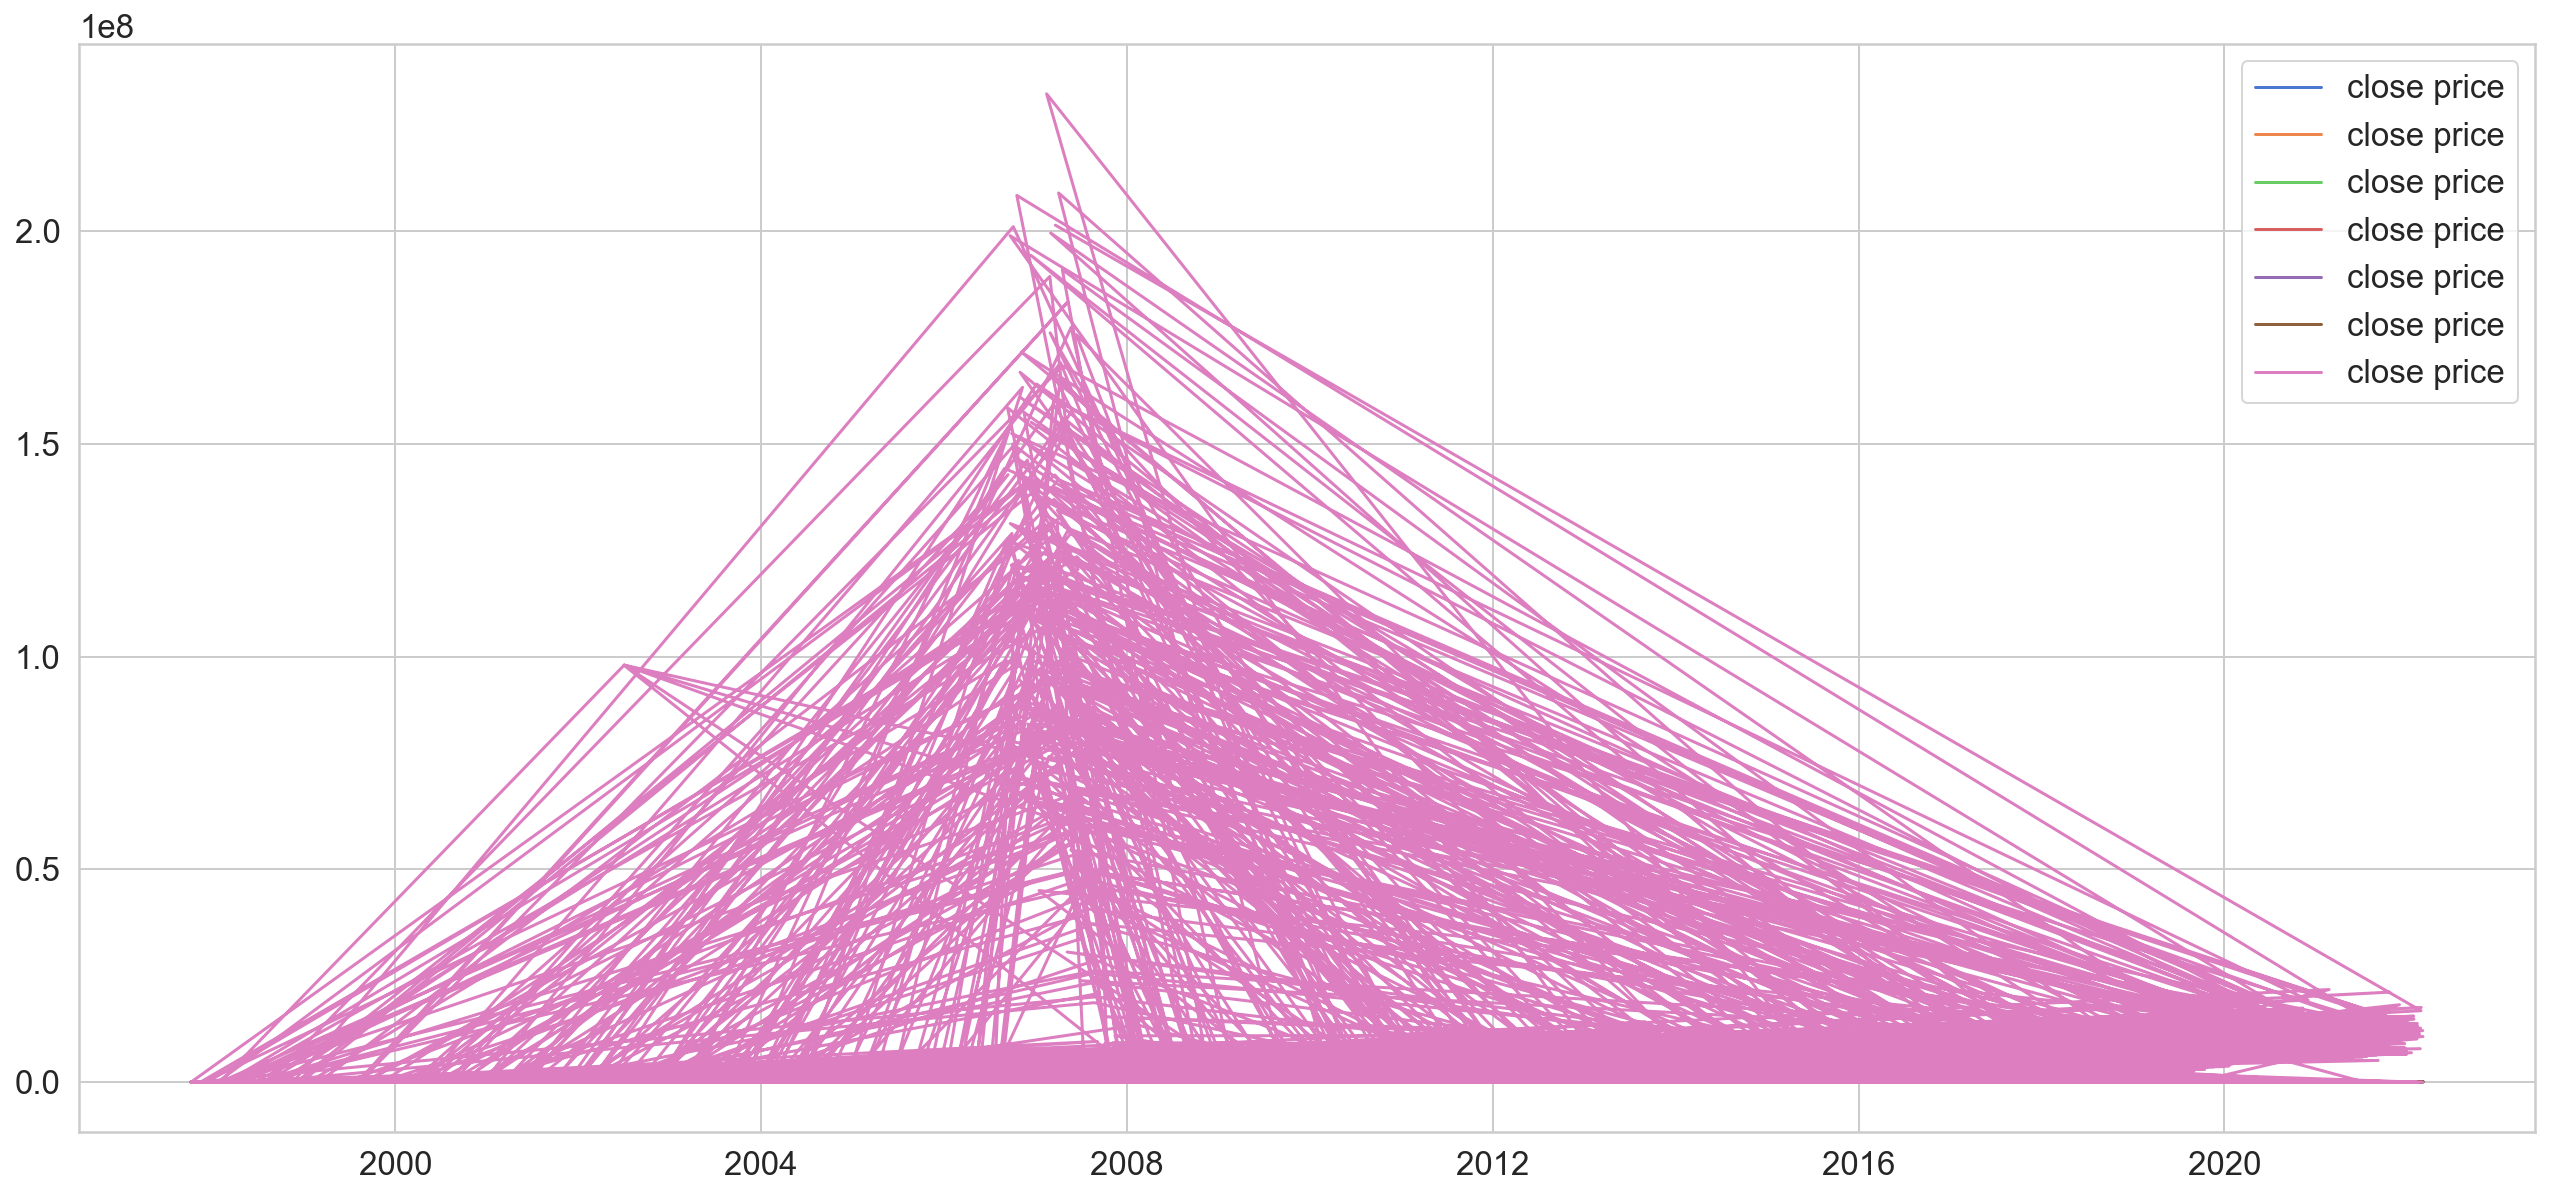

In [5]:
plt.plot(df, label='close price')
plt.legend()

### Introduce an Anomaly

In [6]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(5848, 7) (308, 7)


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

C:\Users\Lucas Silva\AppData\Local\Temp\ipykernel_6560\1564450779.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = scaler.transform(train[['Close']])
C:\Users\Lucas Silva\AppData\Local\Temp\ipykernel_6560\1564450779.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = scaler.transform(test[['Close']])


In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [9]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['Close']], train.Close, TIME_STEPS)
X_test, y_test = create_dataset(test[['Close']], test.Close, TIME_STEPS)

print(X_train.shape)

(5818, 30, 1)


In [10]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            65        
 ibuted)                                                

In [11]:
history = model.fit(
                    X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], 
                    shuffle=False)


Epoch 1/100
164/164 [==============================] - 9s 29ms/step - loss: nan - val_loss: nan
Epoch 2/100
164/164 [==============================] - 4s 25ms/step - loss: nan - val_loss: nan
Epoch 3/100
164/164 [==============================] - 4s 24ms/step - loss: nan - val_loss: nan


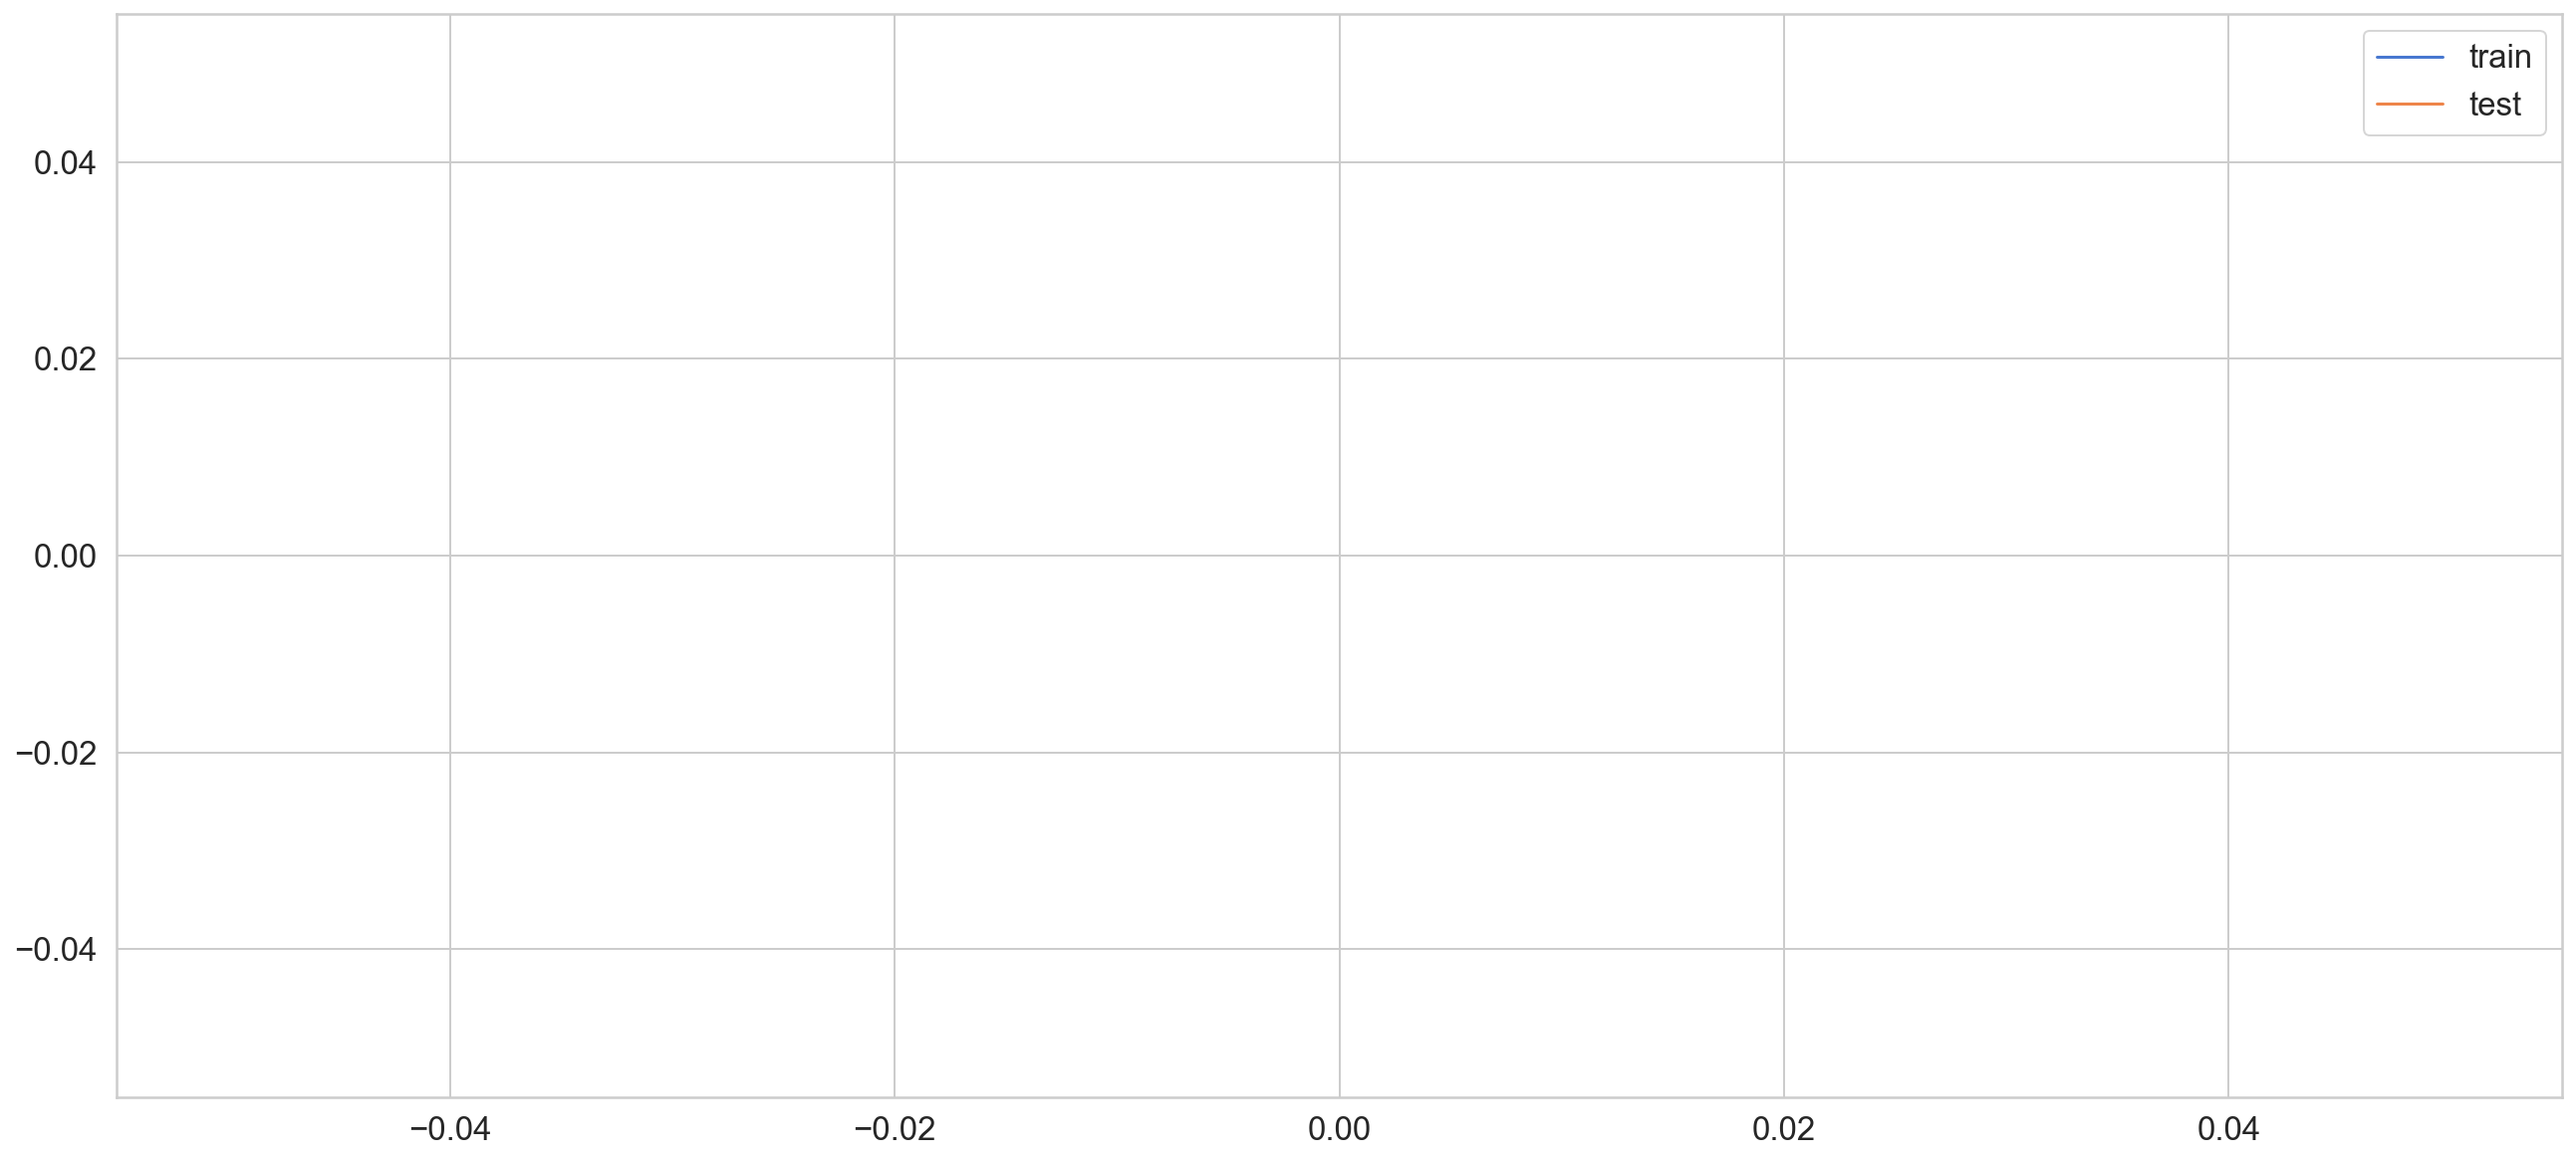

In [125]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

## Seasonal Decompose

In [12]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

d:\Lucas Programacao\10 Seletivo - Anomalia\Aprendizado-de-maquina-Anomalias-Seletivo-\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\Lucas Programacao\10 Seletivo - Anomalia\Aprendizado-de-maquina-Anomalias-Seletivo-\venv\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
d:\Lucas Programacao\10 Seletivo - Anomalia\Aprendizado-de-maquina-Anomalias-Seletivo-\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Lucas Programacao\10 Seletivo - Anomalia\Aprendizado-de-maquina-Anomalias-Seletivo-\venv\lib\site-packages\numpy\lib\histograms.py:

<AxesSubplot:>

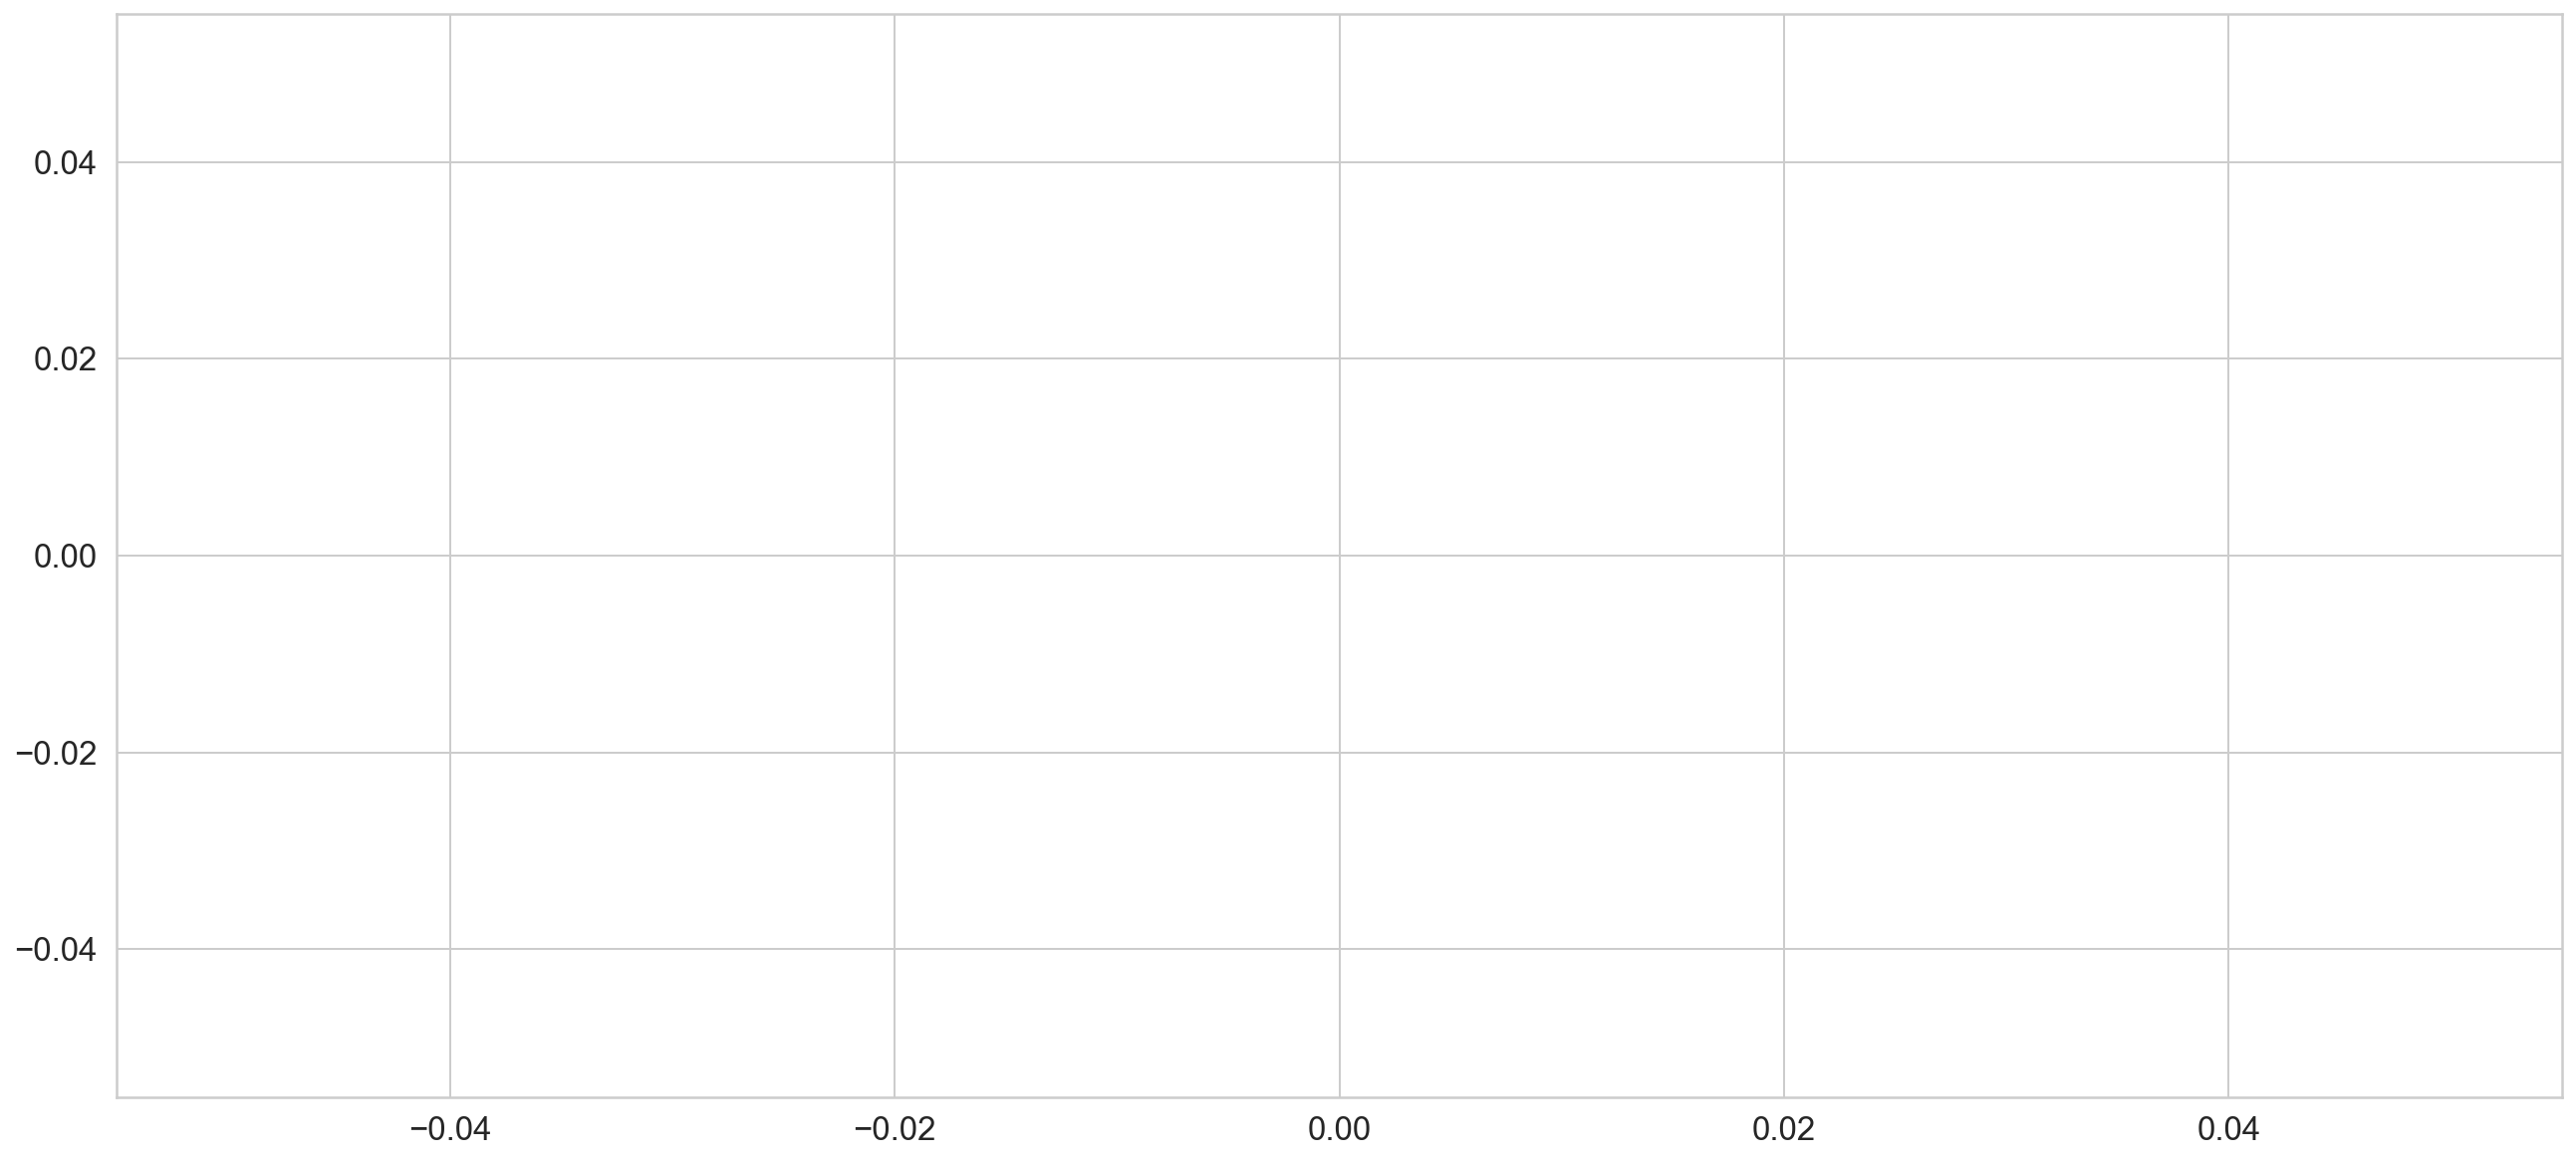

In [13]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [14]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

### Introduce some more point outliers

In [ ]:
catfish_sales.loc["1993-3-1"]['Total'] = 30000
catfish_sales.loc["2003-3-1"]['Total'] = 35000

## Isolation forest

In [16]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].Close

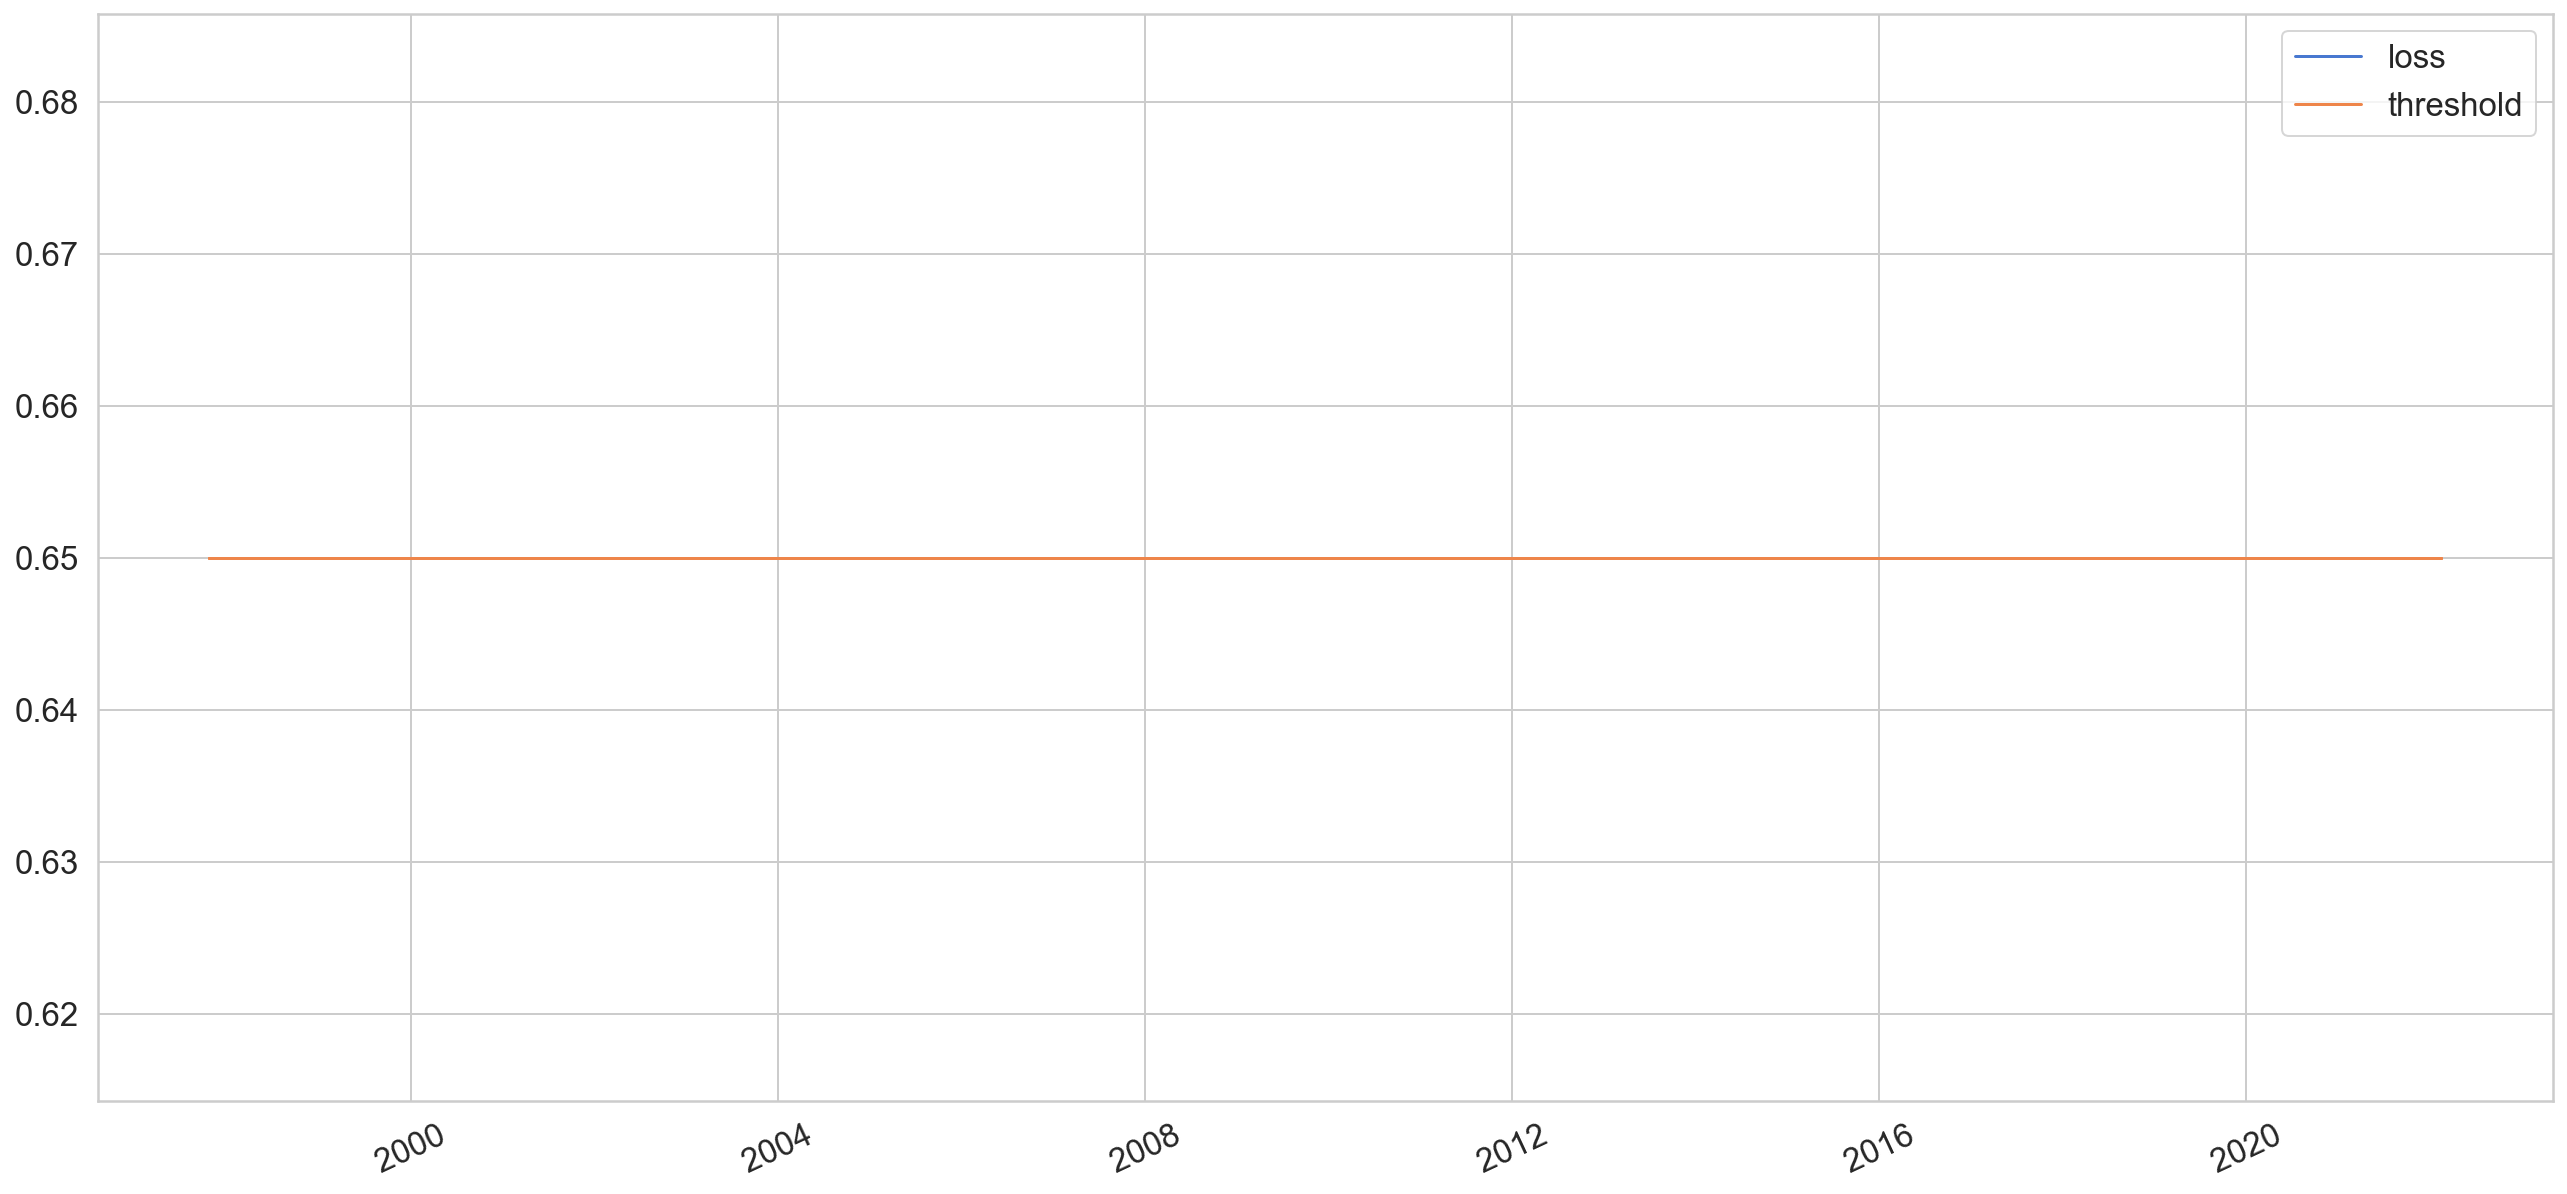

In [17]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend()

In [18]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
Date,,,,


In [20]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].Close), 
  label='close price'
)

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.Close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend()

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.04981065  0.14461842  0.22869263 -1.20128661  0.16660756  2.22207018
 -0.03426356 -1.13163258 -0.04829224  1.2210423   0.06723231 -1.02429687
 -1.20458171  1.16502545  0.67845863  0.0243959  -0.40015111  1.62624278
  0.00566924 -0.76359179  1.09778566 -1.29681213         nan  0.30761211
 -0.97323899  0.15580874  0.94771141  1.75918899 -1.19094453  2.3968088
 -0.44253077 -0.2421164   1.86818857 -1.14354064  1.72000656 -1.19149916
  0.64658417  0.96206634  0.36702194 -1.39977612  0.29247419  0.56629444
 -1.00596171 -0.42530486  0.16957642         nan  0.53647534  0.13949632
  2.20706275  1.26900081  1.49489518 -0.7923669   0.46408083  0.51017972
  0.42026567  0.34604417  0.42160329  0.68795246 -0.93421969 -0.78434119
         nan  0.26467782  0.6458338   0.60211651  0.15375338  2.12510916
  0.2645147  -0.15357259  2.11930194 -0.41238542 -1.28904742  0.12752301
 -0.42882834 -1.29890012  0.37341641  0.228921    2.48075251  0.11183046
 -0.30338584  0.32111879 -1.297693    0.06925505 -0.26736802  0.20415875
  0.22533227 -1.25133311 -0.51841614  0.50117527 -1.37814585  0.16301883
  0.31188596  0.39690629  0.32111879 -1.18396282  1.79390181 -0.03348056
  0.61311108  2.24852892  1.91484208         nan  0.23538072  0.55203739
  1.50275777         nan  0.62479078 -1.33260158  0.4250289  -0.7917144
 -1.40581171  0.76370733  0.00439687  0.21048797  0.0446233   0.25410738
 -0.9481505   0.62616102  0.11783343 -0.8717105   0.13913745 -0.86286917
  0.13039399  0.31191859 -1.3074152   0.35818061 -1.247255   -0.75207522
  0.56352133  0.47027955 -1.18406069  0.30004315 -0.59469301  1.85960824
  1.46217247  1.56135197  1.85389889  0.04788578 -0.76590816  1.57541328
  0.19645929  0.27453052 -0.36041405 -0.86052018  0.55399488  1.47926788
 -0.03197982 -0.54696287 -0.82156613  0.31844356 -1.05274572 -1.26085956
 -1.1918254   0.20415875 -1.06449066  1.88707835 -0.0812107  -1.28493669
  1.27213279 -1.22624461 -0.4374413   0.38000662  0.38480247  0.54424005
 -1.06592616 -0.85774707 -1.13036021  0.14305243 -0.96354942  0.2890812
  0.12125904 -0.17950933 -1.27231088 -1.27123426 -0.15774857  0.04113244
 -1.1069682  -1.11897414 -1.27172363 -0.04959723 -1.2827182   0.60205126
 -1.15375222  1.77905751 -0.88613068 -1.04178378  0.87805739  2.26056748
 -1.20118873  2.06550358  0.60322576  0.6493899   0.24138369 -1.12210613
 -1.30056399  0.43403335  0.47465128 -1.32209638  1.79461956 -0.85484346
 -0.91200218  0.65301126  0.19499117  1.55795899 -0.79151865 -1.23247595
 -1.02569973 -1.16448579  0.12109592 -1.1316652   0.56678382 -0.77001888
  0.05659661 -0.17582273         nan -0.04790074  0.08243548  1.4117671
  0.10713249  0.04217644 -0.80512321 -0.92495424 -1.25926094  1.73344799
 -0.40328309  1.7174292  -1.14063703  0.20735599  0.52110904 -0.88782717
  1.6618691  -1.18879129  0.68005725  0.45709911 -0.9522286   0.05613987
 -0.31946988  0.19616567  0.47083417 -1.20487534 -0.4120918  -0.8060367
 -0.85327747  2.53605161  0.46453758  1.9771229   1.5204078  -1.2128358
  0.30627449 -1.24875574  0.24732141 -1.25906519  1.99872054  0.33221124
 -0.8866853  -0.23523255 -1.36998964 -1.28317495  0.9501909   1.83641198
 -1.30330447 -0.44615213  0.62514965 -1.0177719   0.26683106 -0.01468866
 -0.4065782  -1.0565302   0.71016997 -0.22143225  0.38333436 -1.33811517
 -1.05626921 -0.03302381  0.54410955  0.39821128 -0.39388714  0.04827728
 -1.05838982 -0.39088565].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 

IsolationForest(contamination=0.01)

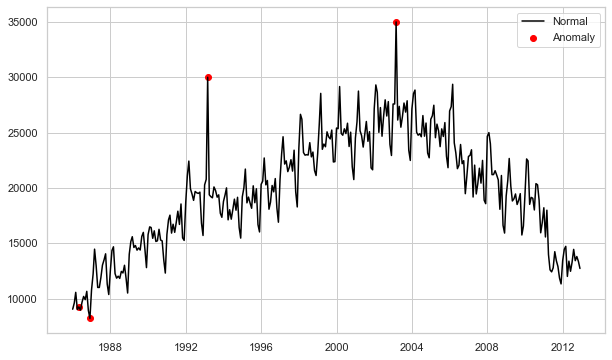

In [ ]:
catfish_sales['anomaly'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = catfish_sales.loc[catfish_sales['anomaly'] == -1, ['Total']] #anomaly

ax.plot(catfish_sales.index, catfish_sales['Total'], color='black', label = 'Normal')
ax.scatter(a.index,a['Total'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

## Kmeans

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
df = pd.read_csv('TimeSeriesExpedia.csv')

In [ ]:
df

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,63,2013-05-23 11:56:25,14,100,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.30,15,69.87,1,8192,4,25,3,0,1,0,NaN,1937.85,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,90,2013-04-23 11:12:24,14,100,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,6,97.49,1,8192,2,44,1,0,1,1,NaN,1208.63,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,133,2013-03-14 11:27:28,5,219,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,29,206.00,1,8192,3,99,1,0,1,1,NaN,397.74,1,NaN,NaN,NaN,-1.0,0.0,2.0,-1.0,0.0,2.0,NaN,NaN,NaN,-1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,148,2013-03-21 02:24:03,10,4,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,33,127.71,1,8192,4,227,1,0,1,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4,203,2013-01-03 20:48:24,5,219,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,6,186.00,1,8192,3,6,2,0,1,0,NaN,222.13,0,NaN,NaN,NaN,1.0,0.0,14.0,0.0,0.0,20.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,14.0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,6290,2013-01-24 22:08:31,5,219,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,2,90.00,1,8192,1,1,4,1,2,1,NaN,212.58,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,6.0,0,NaN,0
50,6299,2013-05-20 10:25:55,14,100,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.30,31,131.82,1,8192,7,30,4,0,1,0,NaN,1036.40,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
51,6363,2012-12-27 11:21:45,5,219,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,22,46.00,1,8192,2,6,2,0,1,0,NaN,257.11,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
52,6551,2013-05-12 06:11:34,5,219,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.30,16,141.00,1,8192,2,145,1,0,1,1,NaN,1688.51,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


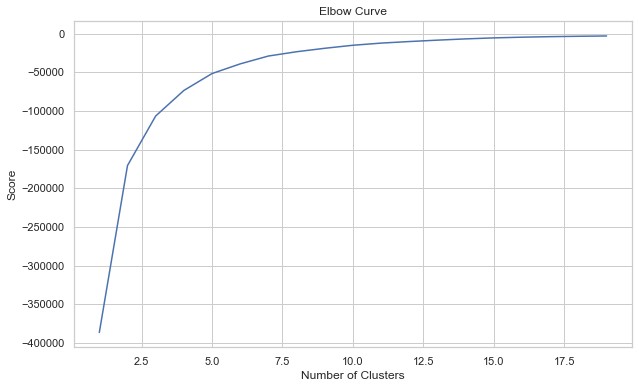

In [ ]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

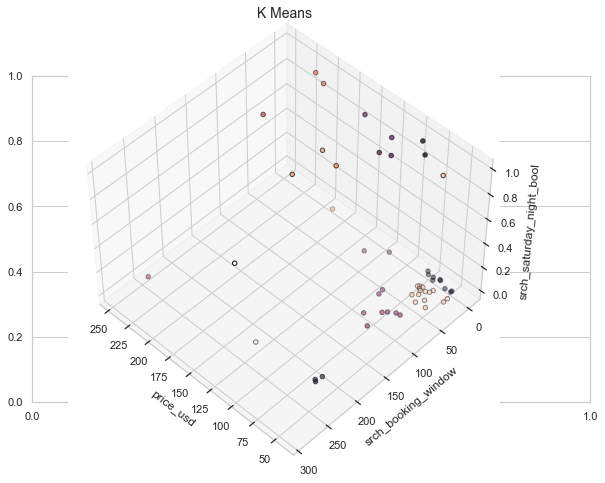

In [ ]:
X = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_
# #Plotting
fig,ax = plt.subplots(figsize=(10,6))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14);

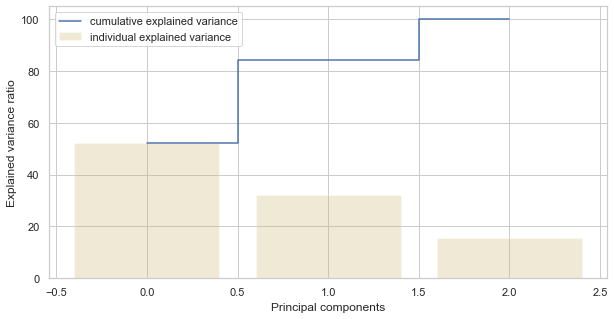

In [ ]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = data.values
X_std = StandardScaler().fit_transform(X)
#Calculating Eigenvecors and eigenvalues of Covariance matrix
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'y')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [ ]:
# Take useful feature and standardize them
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [ ]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[9].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

9    12
0    12
4     8
2     7
1     4
8     3
6     3
7     2
5     2
3     1
Name: cluster, dtype: int64

In [ ]:
kmeans[9]

KMeans(n_clusters=10)

In [ ]:
# return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i]=np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.1
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

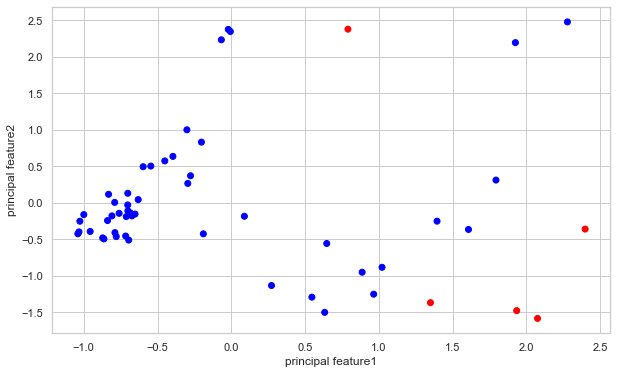

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

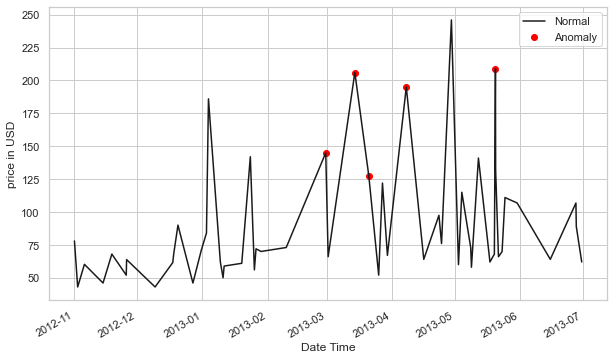

In [ ]:
df = df.sort_values('date_time')
#df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly1'] == 1, ['date_time', 'price_usd']] #anomaly


ax.plot(pd.to_datetime(df['date_time']), df['price_usd'], color='k',label='Normal')
ax.scatter(pd.to_datetime(a['date_time']),a['price_usd'], color='red', label='Anomaly')
ax.xaxis_date()
plt.xlabel('Date Time')
plt.ylabel('price in USD')
plt.legend()
fig.autofmt_xdate()
plt.show()

## Forecasting

In [ ]:
from fbprophet import Prophet

In [ ]:
t = pd.DataFrame()
t['ds'] = catfish_sales.index
t['y'] = catfish_sales['Total'].values

In [ ]:
t

,ds,y
0,1986-01-01,9034
1,1986-02-01,9596
2,1986-03-01,10558
3,1986-04-01,9002
4,1986-05-01,9239
...,...,...
319,2012-08-01,14442
320,2012-09-01,13422
321,2012-10-01,13795
322,2012-11-01,13352


In [ ]:
import altair as alt
#alt.renderers.enable('notebook')

In [ ]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'additive', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast
    
pred = fit_predict_model(t)

In [ ]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [ ]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)

alt.LayerChart(...)

# Autoencoders

In [ ]:
!pip install pyod

     |████████████████████████████████| 101 kB 276 kB/s ta 0:00:01
  Using cached numba-0.52.0-cp36-cp36m-manylinux2014_x86_64.whl (3.1 MB)
  Using cached llvmlite-0.35.0-cp36-cp36m-manylinux2010_x86_64.whl (25.3 MB)
  Created wheel for pyod: filename=pyod-0.8.7-py3-none-any.whl size=115977 sha256=8e4aa898bd8f04ddda80d2219e414a14dda27e4256e137c130c00929d325436d
  Stored in directory: /home/aayush/.cache/pip/wheels/5f/60/ff/d2f452974dc59514fba1876d050eb4cf8b7a10c007e97cf0ab
Successfully built pyod
You should consider upgrading via the '/media/aayush/New-Volume/Neptuneai/neptuneai/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import pandas as pd
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data

contamination = 0.1  # percentage of outliers
n_train = 500  # number of training points
n_test = 500  # number of testing points
n_features = 25 # Number of features

X_train, y_train, X_test, y_test = generate_data(
    n_train=n_train, n_test=n_test,
    n_features= n_features, 
    contamination=contamination,random_state=1234)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [ ]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

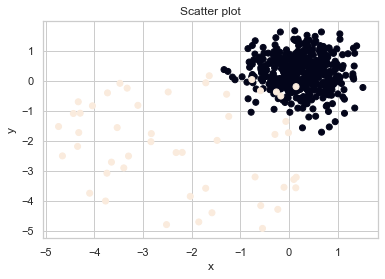

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']
cdict = {0: 'red', 1: 'blue'}
# Plot
import matplotlib.pyplot as plt
plt.scatter(X_train[0], X_train[1], c=y_train, alpha=1)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
clf = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
clf.fit(X_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                650       
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 5

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f895a94c400>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

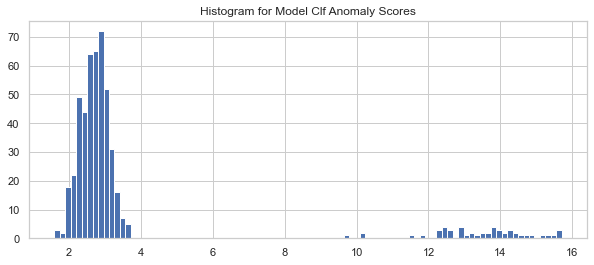

In [ ]:
# Get the outlier scores for the train data
y_train_scores = clf.decision_scores_  

# Predict the anomaly scores
y_test_scores = clf.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

# Plot it!
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram for Model Clf Anomaly Scores")
plt.show()

In [ ]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

t = df_test.groupby('cluster').mean()

In [ ]:
pd.set_option('display.max_rows', 500)
t.T

cluster,0,1
0,0.248812,-2.239305
1,0.235591,-2.120321
2,0.254013,-2.286113
3,0.239429,-2.154863
4,0.239101,-2.151912
5,0.255499,-2.299489
6,0.257207,-2.314860
7,0.244380,-2.199420
8,0.248004,-2.232040
9,0.251948,-2.267535


# What to do about the anomaly?

## Simple Idea: use mean of other months

In [ ]:
adjusted_data = lim_catfish_sales.copy()
adjusted_data.loc[curr_anomaly] = december_data[(december_data.index != curr_anomaly) & (december_data.index < test_data.index[0])].mean()

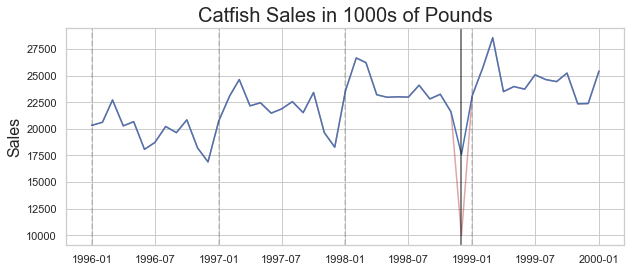

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales, color='firebrick', alpha=0.4)
plt.plot(adjusted_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)

# Resulting Predictions

In [ ]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = adjusted_data[train_end + timedelta(days=1):test_end]

In [ ]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = adjusted_data[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

In [ ]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

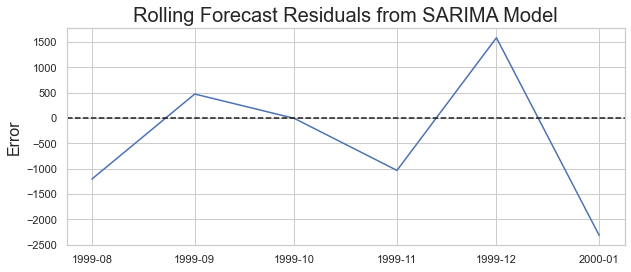

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

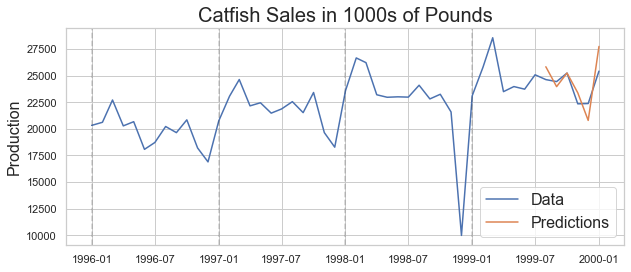

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [ ]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0461


In [ ]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1329.8806978276243
